# Exercise 1:

### a)

y is the label of the response, which has value of -1 and 1.

At the beginning, The kernel logistic function can be presented as following, $f\in \mathcal{H}$ expanded by the kernel function k:

$$
\begin{aligned}
Objective\ &function:  \\
L &= \text{Negative Log-likelihood +Regularization} \\
&= \sum^{N}_{i=1} log(1 + e^{-Y_i f(x_i)}) + \lambda {\left\Vert f\right\Vert} ^{2}\\
\end{aligned}
$$

Because this function is monotonic increasing with the increase of the norm of f. Thus, due to the representer theorem, f(x) can be represented by $\sum^{N}_{i=1} \alpha_i k(x_i, x)$, then we can rewrite the function as 

$$
\begin{aligned}
{\left\Vert f\right\Vert} ^{2} &= {\left\Vert\sum^{N}_{i=1} \alpha_i k(x_i, \cdot)\right\Vert}^{2}= \alpha^T K\alpha\\
f(x_i) &= \sum^{N}_{j=1} \alpha_j k(x_i, x_j) = (K\alpha)_i \\
Final\ Objective\ &function:\\
L &=  \sum^{N}_{i=1} log(1 + e^{-Y_i (K\alpha)_i}) + \lambda \alpha^T K\alpha\\
\end{aligned}
$$

Which is the form we want here.

# b)

F is obvious differentable with smooth functions like logarithm and exponential. We shall first derive the formula for gradient of F.

$$
\begin{aligned}
\frac{\partial{F}}{\partial{\alpha}} &=  \sum^{N}_{i=1} \frac{1}{1 + e^{-Y_i (K\alpha)_i})} 
\frac{\partial{(1 + e^{-Y_i(K\alpha)_i})}}{\partial{\alpha}} + 2\lambda K\alpha\\ 
& = \sum^{N}_{i=1} \frac{-e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})} 
\frac{\partial{(Y_i(K\alpha)_i)}}{\partial{\alpha}} + 2\lambda K\alpha\\
& = \sum^{N}_{i=1} \frac{-e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})} 
Y_iK_i + 2\lambda K\alpha
\end{aligned}
$$

In the former part of the gradient, the 


The latter part is linear in $\alpha$. So it is L-smooth with some sufficient large L.

In the former part of the gradient, the $Y_iK_i$ is constant vector, while $\frac{e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})}$ has bounded gradient:

$$
\begin{aligned}
\frac{\partial{\frac{-e^{-Y_i(K\alpha)_i}}{1 + e^{-Y_i (K\alpha)_i})}}}{\partial \alpha} = 
\frac{e^{-Y_i(K\alpha)_i}}{(1 + e^{-Y_i (K\alpha)_i})^2} *Y_i K_i
\end{aligned}
$$

With ease we can find this is a vector with the elements whose absolute value's uniformly lower than $\frac{1}{4}max(K_i)$. Then we can apply mean value theorem and cauchy schwarz inequality to find a suitable L for our problem.

$$
\begin{aligned}
\left\vert \nabla F(\alpha_1) -\nabla F(\alpha_2) \right\vert &\leq \sum^{N}_{i=1} \frac{1}{4}max(K_i) \left\vert \alpha_1 -\alpha_2 \right\vert + 2\lambda \left\vert K \right\vert \left\vert \alpha_1 -\alpha_2 \right\vert \\
&\leq (\frac{n}{4}max(K) +  2\lambda \left\vert K \right\vert) \left\vert \alpha_1 -\alpha_2 \right\vert 
\end{aligned}
$$

where $max(K)$ is the biggest element in the gram matrix. This is can be regarded as a reasonable L. Thus we have that this function is L smooth.

### c)

I will still use LFW dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

lfw = fetch_lfw_people(min_faces_per_person=70)
mask = np.isin(lfw.target, [3, 4])
X= lfw.data[mask]
y= lfw.target[mask]
y[y==3]=1
y[y==4]=-1


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1209)

### d)

For the stepsize, $\frac{1}{L}$ is a reasonable start point.

In [48]:
lambd = 0.01

def RBF(x,y, sigma = 1):
    return np.exp(- np.linalg.norm(x-y)**2/(2*sigma))

def loss_function(GRAM, alpha,N):

    
    temp1 = np.dot(GRAM, alpha)
    L = np.sum(np.log(1 + np.exp(- temp1* y_train.reshape(N,1))))
    L += lambd * np.dot(np.dot(alpha.T, GRAM), alpha)
    return L

def mysvm_grad(eps= 1e-4, alpha_search= 0.5, beta= 0.5,verbose=True,**kwarg):
    N = len(X_train)
    GRAM = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            GRAM[i,j] = RBF(X_train[i],X_train[j],**kwarg)
    eta =1/(N/4 * np.amax(GRAM) +2*lambd*np.linalg.det(GRAM))
    print("Initial learning rate is ", eta)
    
    alpha = np.random.randn(N).reshape(N,1)
    diff = 1000
    count = 0
    while(np.abs(diff) > eps):
        temp1 = np.dot(GRAM, alpha)
        coeff = 1- 1/(1 + np.exp(- temp1* y_train.reshape(N,1)))
        grad = -np.dot(GRAM,coeff* y_train.reshape(N,1))
        grad += 2* lambd * temp1
        
        #search for another step size
        eta1 = eta
        L= loss_function(GRAM, alpha, N)
        L_new =loss_function(GRAM, alpha- eta1* grad, N) 
        while(L_new>= L- alpha_search*eta1* np.sum(grad*grad)):
            eta1 *= beta
            L_new =loss_function(GRAM, alpha- eta1* grad, N) 
    
        alpha -= eta1 * grad
        count += 1
        diff = L_new - L
        if verbose:
            print('Round %d' % count)
            print('Loss is %f'%L_new )
            print('Difference now is %f' %diff)
    return GRAM, alpha

In [38]:
GRAM, alpha = mysvm_grad(sigma=1e6)
# np.amax(X_train)
# y_train.shapep

[[  1.00000000e+00   1.46897042e-03   1.22363707e-02 ...,   5.49479453e-04
    1.49894185e-03   5.01949661e-03]
 [  1.46897042e-03   1.00000000e+00   4.52747277e-05 ...,   1.70665170e-04
    1.11895727e-03   1.89257153e-04]
 [  1.22363707e-02   4.52747277e-05   1.00000000e+00 ...,   1.89302091e-02
    7.59192848e-03   6.85556979e-02]
 ..., 
 [  5.49479453e-04   1.70665170e-04   1.89302091e-02 ...,   1.00000000e+00
    5.20545354e-02   4.03799037e-03]
 [  1.49894185e-03   1.11895727e-03   7.59192848e-03 ...,   5.20545354e-02
    1.00000000e+00   2.15736132e-03]
 [  5.01949661e-03   1.89257153e-04   6.85556979e-02 ...,   4.03799037e-03
    2.15736132e-03   1.00000000e+00]]
Initial learning rate is  0.00782778864971
Round 1
Loss is 294.926917
Difference now is -85.931597
Round 2
Loss is 289.815548
Difference now is -5.111370
Round 3
Loss is 285.776427
Difference now is -4.039121
Round 4
Loss is 282.066558
Difference now is -3.709868
Round 5
Loss is 278.562104
Difference now is -3.504454
R

Round 252
Loss is 100.716275
Difference now is -0.214157
Round 253
Loss is 100.503276
Difference now is -0.212999
Round 254
Loss is 100.291425
Difference now is -0.211851
Round 255
Loss is 100.080714
Difference now is -0.210711
Round 256
Loss is 99.871135
Difference now is -0.209579
Round 257
Loss is 99.662678
Difference now is -0.208457
Round 258
Loss is 99.455335
Difference now is -0.207343
Round 259
Loss is 99.249098
Difference now is -0.206237
Round 260
Loss is 99.043958
Difference now is -0.205140
Round 261
Loss is 98.839907
Difference now is -0.204051
Round 262
Loss is 98.636937
Difference now is -0.202970
Round 263
Loss is 98.435039
Difference now is -0.201898
Round 264
Loss is 98.234206
Difference now is -0.200833
Round 265
Loss is 98.034430
Difference now is -0.199776
Round 266
Loss is 97.835702
Difference now is -0.198727
Round 267
Loss is 97.638016
Difference now is -0.197686
Round 268
Loss is 97.441363
Difference now is -0.196653
Round 269
Loss is 97.245736
Difference now i

Round 523
Loss is 67.976446
Difference now is -0.066134
Round 524
Loss is 67.910549
Difference now is -0.065897
Round 525
Loss is 67.844887
Difference now is -0.065662
Round 526
Loss is 67.779459
Difference now is -0.065428
Round 527
Loss is 67.714265
Difference now is -0.065195
Round 528
Loss is 67.649302
Difference now is -0.064962
Round 529
Loss is 67.584571
Difference now is -0.064731
Round 530
Loss is 67.520069
Difference now is -0.064502
Round 531
Loss is 67.455796
Difference now is -0.064273
Round 532
Loss is 67.391751
Difference now is -0.064045
Round 533
Loss is 67.327933
Difference now is -0.063818
Round 534
Loss is 67.264341
Difference now is -0.063593
Round 535
Loss is 67.200973
Difference now is -0.063368
Round 536
Loss is 67.137828
Difference now is -0.063144
Round 537
Loss is 67.074907
Difference now is -0.062922
Round 538
Loss is 67.012206
Difference now is -0.062700
Round 539
Loss is 66.949726
Difference now is -0.062480
Round 540
Loss is 66.887466
Difference now is -0

Round 795
Loss is 56.097927
Difference now is -0.028325
Round 796
Loss is 56.069679
Difference now is -0.028248
Round 797
Loss is 56.041508
Difference now is -0.028171
Round 798
Loss is 56.013413
Difference now is -0.028095
Round 799
Loss is 55.985395
Difference now is -0.028018
Round 800
Loss is 55.957453
Difference now is -0.027942
Round 801
Loss is 55.929586
Difference now is -0.027867
Round 802
Loss is 55.901795
Difference now is -0.027791
Round 803
Loss is 55.874079
Difference now is -0.027716
Round 804
Loss is 55.846437
Difference now is -0.027641
Round 805
Loss is 55.818871
Difference now is -0.027567
Round 806
Loss is 55.791378
Difference now is -0.027492
Round 807
Loss is 55.763960
Difference now is -0.027418
Round 808
Loss is 55.736615
Difference now is -0.027345
Round 809
Loss is 55.709344
Difference now is -0.027271
Round 810
Loss is 55.682147
Difference now is -0.027198
Round 811
Loss is 55.655022
Difference now is -0.027125
Round 812
Loss is 55.627970
Difference now is -0

Round 1076
Loss is 50.410368
Difference now is -0.014311
Round 1077
Loss is 50.396088
Difference now is -0.014280
Round 1078
Loss is 50.381838
Difference now is -0.014249
Round 1079
Loss is 50.367620
Difference now is -0.014219
Round 1080
Loss is 50.353432
Difference now is -0.014188
Round 1081
Loss is 50.339275
Difference now is -0.014157
Round 1082
Loss is 50.325149
Difference now is -0.014126
Round 1083
Loss is 50.311053
Difference now is -0.014096
Round 1084
Loss is 50.296987
Difference now is -0.014066
Round 1085
Loss is 50.282952
Difference now is -0.014035
Round 1086
Loss is 50.268947
Difference now is -0.014005
Round 1087
Loss is 50.254972
Difference now is -0.013975
Round 1088
Loss is 50.241028
Difference now is -0.013945
Round 1089
Loss is 50.227113
Difference now is -0.013915
Round 1090
Loss is 50.213228
Difference now is -0.013885
Round 1091
Loss is 50.199373
Difference now is -0.013855
Round 1092
Loss is 50.185548
Difference now is -0.013825
Round 1093
Loss is 50.171752
Di

Round 1346
Loss is 47.444683
Difference now is -0.008384
Round 1347
Loss is 47.436313
Difference now is -0.008369
Round 1348
Loss is 47.427959
Difference now is -0.008354
Round 1349
Loss is 47.419620
Difference now is -0.008339
Round 1350
Loss is 47.411296
Difference now is -0.008324
Round 1351
Loss is 47.402988
Difference now is -0.008309
Round 1352
Loss is 47.394694
Difference now is -0.008294
Round 1353
Loss is 47.386415
Difference now is -0.008279
Round 1354
Loss is 47.378150
Difference now is -0.008264
Round 1355
Loss is 47.369901
Difference now is -0.008249
Round 1356
Loss is 47.361667
Difference now is -0.008234
Round 1357
Loss is 47.353447
Difference now is -0.008220
Round 1358
Loss is 47.345242
Difference now is -0.008205
Round 1359
Loss is 47.337052
Difference now is -0.008190
Round 1360
Loss is 47.328876
Difference now is -0.008176
Round 1361
Loss is 47.320715
Difference now is -0.008161
Round 1362
Loss is 47.312569
Difference now is -0.008146
Round 1363
Loss is 47.304437
Di

Difference now is -0.005377
Round 1613
Loss is 45.650556
Difference now is -0.005369
Round 1614
Loss is 45.645195
Difference now is -0.005360
Round 1615
Loss is 45.639843
Difference now is -0.005352
Round 1616
Loss is 45.634499
Difference now is -0.005344
Round 1617
Loss is 45.629163
Difference now is -0.005336
Round 1618
Loss is 45.623836
Difference now is -0.005328
Round 1619
Loss is 45.618516
Difference now is -0.005319
Round 1620
Loss is 45.613205
Difference now is -0.005311
Round 1621
Loss is 45.607902
Difference now is -0.005303
Round 1622
Loss is 45.602607
Difference now is -0.005295
Round 1623
Loss is 45.597321
Difference now is -0.005287
Round 1624
Loss is 45.592042
Difference now is -0.005279
Round 1625
Loss is 45.586771
Difference now is -0.005271
Round 1626
Loss is 45.581509
Difference now is -0.005262
Round 1627
Loss is 45.576255
Difference now is -0.005254
Round 1628
Loss is 45.571008
Difference now is -0.005246
Round 1629
Loss is 45.565770
Difference now is -0.005238
Rou

Difference now is -0.003793
Round 1854
Loss is 44.563036
Difference now is -0.003788
Round 1855
Loss is 44.559253
Difference now is -0.003783
Round 1856
Loss is 44.555475
Difference now is -0.003778
Round 1857
Loss is 44.551702
Difference now is -0.003773
Round 1858
Loss is 44.547935
Difference now is -0.003768
Round 1859
Loss is 44.544172
Difference now is -0.003763
Round 1860
Loss is 44.540415
Difference now is -0.003758
Round 1861
Loss is 44.536662
Difference now is -0.003752
Round 1862
Loss is 44.532915
Difference now is -0.003747
Round 1863
Loss is 44.529173
Difference now is -0.003742
Round 1864
Loss is 44.525435
Difference now is -0.003737
Round 1865
Loss is 44.521703
Difference now is -0.003732
Round 1866
Loss is 44.517976
Difference now is -0.003727
Round 1867
Loss is 44.514254
Difference now is -0.003722
Round 1868
Loss is 44.510537
Difference now is -0.003717
Round 1869
Loss is 44.506825
Difference now is -0.003712
Round 1870
Loss is 44.503118
Difference now is -0.003707
Rou

Round 2103
Loss is 43.758219
Difference now is -0.002756
Round 2104
Loss is 43.755467
Difference now is -0.002752
Round 2105
Loss is 43.752718
Difference now is -0.002749
Round 2106
Loss is 43.749972
Difference now is -0.002746
Round 2107
Loss is 43.747229
Difference now is -0.002742
Round 2108
Loss is 43.744490
Difference now is -0.002739
Round 2109
Loss is 43.741755
Difference now is -0.002736
Round 2110
Loss is 43.739022
Difference now is -0.002733
Round 2111
Loss is 43.736293
Difference now is -0.002729
Round 2112
Loss is 43.733567
Difference now is -0.002726
Round 2113
Loss is 43.730844
Difference now is -0.002723
Round 2114
Loss is 43.728124
Difference now is -0.002719
Round 2115
Loss is 43.725408
Difference now is -0.002716
Round 2116
Loss is 43.722695
Difference now is -0.002713
Round 2117
Loss is 43.719986
Difference now is -0.002710
Round 2118
Loss is 43.717279
Difference now is -0.002706
Round 2119
Loss is 43.714576
Difference now is -0.002703
Round 2120
Loss is 43.711876
Di

Round 2360
Loss is 43.146178
Difference now is -0.002057
Round 2361
Loss is 43.144123
Difference now is -0.002055
Round 2362
Loss is 43.142070
Difference now is -0.002053
Round 2363
Loss is 43.140020
Difference now is -0.002051
Round 2364
Loss is 43.137971
Difference now is -0.002048
Round 2365
Loss is 43.135925
Difference now is -0.002046
Round 2366
Loss is 43.133881
Difference now is -0.002044
Round 2367
Loss is 43.131840
Difference now is -0.002042
Round 2368
Loss is 43.129800
Difference now is -0.002040
Round 2369
Loss is 43.127763
Difference now is -0.002037
Round 2370
Loss is 43.125727
Difference now is -0.002035
Round 2371
Loss is 43.123694
Difference now is -0.002033
Round 2372
Loss is 43.121664
Difference now is -0.002031
Round 2373
Loss is 43.119635
Difference now is -0.002029
Round 2374
Loss is 43.117608
Difference now is -0.002026
Round 2375
Loss is 43.115584
Difference now is -0.002024
Round 2376
Loss is 43.113562
Difference now is -0.002022
Round 2377
Loss is 43.111542
Di

Difference now is -0.001546
Round 2642
Loss is 42.643387
Difference now is -0.001545
Round 2643
Loss is 42.641844
Difference now is -0.001543
Round 2644
Loss is 42.640303
Difference now is -0.001542
Round 2645
Loss is 42.638762
Difference now is -0.001540
Round 2646
Loss is 42.637224
Difference now is -0.001539
Round 2647
Loss is 42.635687
Difference now is -0.001537
Round 2648
Loss is 42.634151
Difference now is -0.001536
Round 2649
Loss is 42.632616
Difference now is -0.001534
Round 2650
Loss is 42.631084
Difference now is -0.001533
Round 2651
Loss is 42.629552
Difference now is -0.001531
Round 2652
Loss is 42.628022
Difference now is -0.001530
Round 2653
Loss is 42.626494
Difference now is -0.001528
Round 2654
Loss is 42.624967
Difference now is -0.001527
Round 2655
Loss is 42.623442
Difference now is -0.001525
Round 2656
Loss is 42.621918
Difference now is -0.001524
Round 2657
Loss is 42.620395
Difference now is -0.001523
Round 2658
Loss is 42.618874
Difference now is -0.001521
Rou

Round 2919
Loss is 42.266329
Difference now is -0.001199
Round 2920
Loss is 42.265131
Difference now is -0.001198
Round 2921
Loss is 42.263934
Difference now is -0.001197
Round 2922
Loss is 42.262738
Difference now is -0.001196
Round 2923
Loss is 42.261542
Difference now is -0.001195
Round 2924
Loss is 42.260348
Difference now is -0.001194
Round 2925
Loss is 42.259155
Difference now is -0.001193
Round 2926
Loss is 42.257963
Difference now is -0.001192
Round 2927
Loss is 42.256772
Difference now is -0.001191
Round 2928
Loss is 42.255582
Difference now is -0.001190
Round 2929
Loss is 42.254393
Difference now is -0.001189
Round 2930
Loss is 42.253205
Difference now is -0.001188
Round 2931
Loss is 42.252018
Difference now is -0.001187
Round 2932
Loss is 42.250832
Difference now is -0.001186
Round 2933
Loss is 42.249647
Difference now is -0.001185
Round 2934
Loss is 42.248463
Difference now is -0.001184
Round 2935
Loss is 42.247280
Difference now is -0.001183
Round 2936
Loss is 42.246098
Di

Round 3127
Loss is 42.037728
Difference now is -0.001007
Round 3128
Loss is 42.036721
Difference now is -0.001007
Round 3129
Loss is 42.035716
Difference now is -0.001006
Round 3130
Loss is 42.034711
Difference now is -0.001005
Round 3131
Loss is 42.033706
Difference now is -0.001004
Round 3132
Loss is 42.032703
Difference now is -0.001003
Round 3133
Loss is 42.031701
Difference now is -0.001003
Round 3134
Loss is 42.030699
Difference now is -0.001002
Round 3135
Loss is 42.029698
Difference now is -0.001001
Round 3136
Loss is 42.028698
Difference now is -0.001000
Round 3137
Loss is 42.027698
Difference now is -0.000999
Round 3138
Loss is 42.026700
Difference now is -0.000999
Round 3139
Loss is 42.025702
Difference now is -0.000998
Round 3140
Loss is 42.024705
Difference now is -0.000997
Round 3141
Loss is 42.023709
Difference now is -0.000996
Round 3142
Loss is 42.022714
Difference now is -0.000995
Round 3143
Loss is 42.021719
Difference now is -0.000994
Round 3144
Loss is 42.020726
Di

Loss is 41.847184
Difference now is -0.000858
Round 3333
Loss is 41.846327
Difference now is -0.000857
Round 3334
Loss is 41.845471
Difference now is -0.000857
Round 3335
Loss is 41.844615
Difference now is -0.000856
Round 3336
Loss is 41.843759
Difference now is -0.000855
Round 3337
Loss is 41.842905
Difference now is -0.000855
Round 3338
Loss is 41.842051
Difference now is -0.000854
Round 3339
Loss is 41.841197
Difference now is -0.000853
Round 3340
Loss is 41.840345
Difference now is -0.000853
Round 3341
Loss is 41.839493
Difference now is -0.000852
Round 3342
Loss is 41.838641
Difference now is -0.000851
Round 3343
Loss is 41.837791
Difference now is -0.000851
Round 3344
Loss is 41.836940
Difference now is -0.000850
Round 3345
Loss is 41.836091
Difference now is -0.000849
Round 3346
Loss is 41.835242
Difference now is -0.000849
Round 3347
Loss is 41.834394
Difference now is -0.000848
Round 3348
Loss is 41.833546
Difference now is -0.000848
Round 3349
Loss is 41.832699
Difference no

Round 3544
Loss is 41.678983
Difference now is -0.000734
Round 3545
Loss is 41.678250
Difference now is -0.000734
Round 3546
Loss is 41.677517
Difference now is -0.000733
Round 3547
Loss is 41.676784
Difference now is -0.000732
Round 3548
Loss is 41.676052
Difference now is -0.000732
Round 3549
Loss is 41.675321
Difference now is -0.000731
Round 3550
Loss is 41.674590
Difference now is -0.000731
Round 3551
Loss is 41.673860
Difference now is -0.000730
Round 3552
Loss is 41.673130
Difference now is -0.000730
Round 3553
Loss is 41.672400
Difference now is -0.000729
Round 3554
Loss is 41.671672
Difference now is -0.000729
Round 3555
Loss is 41.670943
Difference now is -0.000728
Round 3556
Loss is 41.670215
Difference now is -0.000728
Round 3557
Loss is 41.669488
Difference now is -0.000727
Round 3558
Loss is 41.668761
Difference now is -0.000727
Round 3559
Loss is 41.668035
Difference now is -0.000726
Round 3560
Loss is 41.667309
Difference now is -0.000726
Round 3561
Loss is 41.666584
Di

Round 3753
Loss is 41.536303
Difference now is -0.000635
Round 3754
Loss is 41.535669
Difference now is -0.000635
Round 3755
Loss is 41.535034
Difference now is -0.000634
Round 3756
Loss is 41.534400
Difference now is -0.000634
Round 3757
Loss is 41.533767
Difference now is -0.000633
Round 3758
Loss is 41.533134
Difference now is -0.000633
Round 3759
Loss is 41.532501
Difference now is -0.000633
Round 3760
Loss is 41.531869
Difference now is -0.000632
Round 3761
Loss is 41.531237
Difference now is -0.000632
Round 3762
Loss is 41.530606
Difference now is -0.000631
Round 3763
Loss is 41.529975
Difference now is -0.000631
Round 3764
Loss is 41.529345
Difference now is -0.000630
Round 3765
Loss is 41.528715
Difference now is -0.000630
Round 3766
Loss is 41.528085
Difference now is -0.000630
Round 3767
Loss is 41.527456
Difference now is -0.000629
Round 3768
Loss is 41.526827
Difference now is -0.000629
Round 3769
Loss is 41.526199
Difference now is -0.000628
Round 3770
Loss is 41.525571
Di

Round 3963
Loss is 41.411798
Difference now is -0.000554
Round 3964
Loss is 41.411245
Difference now is -0.000553
Round 3965
Loss is 41.410692
Difference now is -0.000553
Round 3966
Loss is 41.410140
Difference now is -0.000553
Round 3967
Loss is 41.409587
Difference now is -0.000552
Round 3968
Loss is 41.409035
Difference now is -0.000552
Round 3969
Loss is 41.408484
Difference now is -0.000552
Round 3970
Loss is 41.407933
Difference now is -0.000551
Round 3971
Loss is 41.407382
Difference now is -0.000551
Round 3972
Loss is 41.406832
Difference now is -0.000550
Round 3973
Loss is 41.406281
Difference now is -0.000550
Round 3974
Loss is 41.405732
Difference now is -0.000550
Round 3975
Loss is 41.405182
Difference now is -0.000549
Round 3976
Loss is 41.404633
Difference now is -0.000549
Round 3977
Loss is 41.404084
Difference now is -0.000549
Round 3978
Loss is 41.403536
Difference now is -0.000548
Round 3979
Loss is 41.402988
Difference now is -0.000548
Round 3980
Loss is 41.402440
Di

Round 4165
Loss is 41.306783
Difference now is -0.000488
Round 4166
Loss is 41.306295
Difference now is -0.000488
Round 4167
Loss is 41.305807
Difference now is -0.000488
Round 4168
Loss is 41.305320
Difference now is -0.000487
Round 4169
Loss is 41.304832
Difference now is -0.000487
Round 4170
Loss is 41.304345
Difference now is -0.000487
Round 4171
Loss is 41.303859
Difference now is -0.000487
Round 4172
Loss is 41.303373
Difference now is -0.000486
Round 4173
Loss is 41.302887
Difference now is -0.000486
Round 4174
Loss is 41.302401
Difference now is -0.000486
Round 4175
Loss is 41.301915
Difference now is -0.000485
Round 4176
Loss is 41.301430
Difference now is -0.000485
Round 4177
Loss is 41.300945
Difference now is -0.000485
Round 4178
Loss is 41.300461
Difference now is -0.000485
Round 4179
Loss is 41.299977
Difference now is -0.000484
Round 4180
Loss is 41.299493
Difference now is -0.000484
Round 4181
Loss is 41.299009
Difference now is -0.000484
Round 4182
Loss is 41.298526
Di

Round 4372
Loss is 41.211706
Difference now is -0.000432
Round 4373
Loss is 41.211274
Difference now is -0.000432
Round 4374
Loss is 41.210842
Difference now is -0.000432
Round 4375
Loss is 41.210411
Difference now is -0.000431
Round 4376
Loss is 41.209980
Difference now is -0.000431
Round 4377
Loss is 41.209549
Difference now is -0.000431
Round 4378
Loss is 41.209118
Difference now is -0.000431
Round 4379
Loss is 41.208688
Difference now is -0.000430
Round 4380
Loss is 41.208258
Difference now is -0.000430
Round 4381
Loss is 41.207828
Difference now is -0.000430
Round 4382
Loss is 41.207398
Difference now is -0.000430
Round 4383
Loss is 41.206969
Difference now is -0.000429
Round 4384
Loss is 41.206540
Difference now is -0.000429
Round 4385
Loss is 41.206111
Difference now is -0.000429
Round 4386
Loss is 41.205682
Difference now is -0.000429
Round 4387
Loss is 41.205254
Difference now is -0.000428
Round 4388
Loss is 41.204826
Difference now is -0.000428
Round 4389
Loss is 41.204398
Di

Round 4583
Loss is 41.125807
Difference now is -0.000384
Round 4584
Loss is 41.125424
Difference now is -0.000383
Round 4585
Loss is 41.125041
Difference now is -0.000383
Round 4586
Loss is 41.124658
Difference now is -0.000383
Round 4587
Loss is 41.124275
Difference now is -0.000383
Round 4588
Loss is 41.123892
Difference now is -0.000383
Round 4589
Loss is 41.123510
Difference now is -0.000382
Round 4590
Loss is 41.123128
Difference now is -0.000382
Round 4591
Loss is 41.122746
Difference now is -0.000382
Round 4592
Loss is 41.122364
Difference now is -0.000382
Round 4593
Loss is 41.121982
Difference now is -0.000382
Round 4594
Loss is 41.121601
Difference now is -0.000381
Round 4595
Loss is 41.121220
Difference now is -0.000381
Round 4596
Loss is 41.120839
Difference now is -0.000381
Round 4597
Loss is 41.120458
Difference now is -0.000381
Round 4598
Loss is 41.120078
Difference now is -0.000380
Round 4599
Loss is 41.119698
Difference now is -0.000380
Round 4600
Loss is 41.119318
Di

Loss is 41.049686
Difference now is -0.000343
Round 4794
Loss is 41.049344
Difference now is -0.000342
Round 4795
Loss is 41.049002
Difference now is -0.000342
Round 4796
Loss is 41.048660
Difference now is -0.000342
Round 4797
Loss is 41.048318
Difference now is -0.000342
Round 4798
Loss is 41.047976
Difference now is -0.000342
Round 4799
Loss is 41.047635
Difference now is -0.000341
Round 4800
Loss is 41.047293
Difference now is -0.000341
Round 4801
Loss is 41.046952
Difference now is -0.000341
Round 4802
Loss is 41.046611
Difference now is -0.000341
Round 4803
Loss is 41.046271
Difference now is -0.000341
Round 4804
Loss is 41.045930
Difference now is -0.000341
Round 4805
Loss is 41.045590
Difference now is -0.000340
Round 4806
Loss is 41.045249
Difference now is -0.000340
Round 4807
Loss is 41.044909
Difference now is -0.000340
Round 4808
Loss is 41.044569
Difference now is -0.000340
Round 4809
Loss is 41.044230
Difference now is -0.000340
Round 4810
Loss is 41.043890
Difference no

Round 5004
Loss is 40.981247
Difference now is -0.000307
Round 5005
Loss is 40.980940
Difference now is -0.000307
Round 5006
Loss is 40.980633
Difference now is -0.000307
Round 5007
Loss is 40.980327
Difference now is -0.000307
Round 5008
Loss is 40.980020
Difference now is -0.000307
Round 5009
Loss is 40.979714
Difference now is -0.000306
Round 5010
Loss is 40.979407
Difference now is -0.000306
Round 5011
Loss is 40.979101
Difference now is -0.000306
Round 5012
Loss is 40.978795
Difference now is -0.000306
Round 5013
Loss is 40.978490
Difference now is -0.000306
Round 5014
Loss is 40.978184
Difference now is -0.000306
Round 5015
Loss is 40.977878
Difference now is -0.000305
Round 5016
Loss is 40.977573
Difference now is -0.000305
Round 5017
Loss is 40.977268
Difference now is -0.000305
Round 5018
Loss is 40.976963
Difference now is -0.000305
Round 5019
Loss is 40.976658
Difference now is -0.000305
Round 5020
Loss is 40.976353
Difference now is -0.000305
Round 5021
Loss is 40.976049
Di

Round 5211
Loss is 40.920855
Difference now is -0.000277
Round 5212
Loss is 40.920578
Difference now is -0.000277
Round 5213
Loss is 40.920301
Difference now is -0.000277
Round 5214
Loss is 40.920024
Difference now is -0.000277
Round 5215
Loss is 40.919747
Difference now is -0.000277
Round 5216
Loss is 40.919471
Difference now is -0.000276
Round 5217
Loss is 40.919195
Difference now is -0.000276
Round 5218
Loss is 40.918918
Difference now is -0.000276
Round 5219
Loss is 40.918642
Difference now is -0.000276
Round 5220
Loss is 40.918366
Difference now is -0.000276
Round 5221
Loss is 40.918090
Difference now is -0.000276
Round 5222
Loss is 40.917815
Difference now is -0.000276
Round 5223
Loss is 40.917539
Difference now is -0.000276
Round 5224
Loss is 40.917264
Difference now is -0.000275
Round 5225
Loss is 40.916989
Difference now is -0.000275
Round 5226
Loss is 40.916713
Difference now is -0.000275
Round 5227
Loss is 40.916438
Difference now is -0.000275
Round 5228
Loss is 40.916164
Di

Round 5418
Loss is 40.866262
Difference now is -0.000251
Round 5419
Loss is 40.866011
Difference now is -0.000251
Round 5420
Loss is 40.865760
Difference now is -0.000251
Round 5421
Loss is 40.865509
Difference now is -0.000251
Round 5422
Loss is 40.865259
Difference now is -0.000251
Round 5423
Loss is 40.865008
Difference now is -0.000250
Round 5424
Loss is 40.864758
Difference now is -0.000250
Round 5425
Loss is 40.864508
Difference now is -0.000250
Round 5426
Loss is 40.864258
Difference now is -0.000250
Round 5427
Loss is 40.864008
Difference now is -0.000250
Round 5428
Loss is 40.863758
Difference now is -0.000250
Round 5429
Loss is 40.863508
Difference now is -0.000250
Round 5430
Loss is 40.863259
Difference now is -0.000250
Round 5431
Loss is 40.863009
Difference now is -0.000249
Round 5432
Loss is 40.862760
Difference now is -0.000249
Round 5433
Loss is 40.862510
Difference now is -0.000249
Round 5434
Loss is 40.862261
Difference now is -0.000249
Round 5435
Loss is 40.862012
Di

Round 5630
Loss is 40.815595
Difference now is -0.000228
Round 5631
Loss is 40.815368
Difference now is -0.000227
Round 5632
Loss is 40.815141
Difference now is -0.000227
Round 5633
Loss is 40.814913
Difference now is -0.000227
Round 5634
Loss is 40.814686
Difference now is -0.000227
Round 5635
Loss is 40.814459
Difference now is -0.000227
Round 5636
Loss is 40.814232
Difference now is -0.000227
Round 5637
Loss is 40.814005
Difference now is -0.000227
Round 5638
Loss is 40.813778
Difference now is -0.000227
Round 5639
Loss is 40.813552
Difference now is -0.000227
Round 5640
Loss is 40.813325
Difference now is -0.000227
Round 5641
Loss is 40.813099
Difference now is -0.000226
Round 5642
Loss is 40.812872
Difference now is -0.000226
Round 5643
Loss is 40.812646
Difference now is -0.000226
Round 5644
Loss is 40.812420
Difference now is -0.000226
Round 5645
Loss is 40.812194
Difference now is -0.000226
Round 5646
Loss is 40.811968
Difference now is -0.000226
Round 5647
Loss is 40.811742
Di

Round 5842
Loss is 40.769582
Difference now is -0.000207
Round 5843
Loss is 40.769375
Difference now is -0.000207
Round 5844
Loss is 40.769168
Difference now is -0.000207
Round 5845
Loss is 40.768961
Difference now is -0.000207
Round 5846
Loss is 40.768755
Difference now is -0.000207
Round 5847
Loss is 40.768548
Difference now is -0.000207
Round 5848
Loss is 40.768342
Difference now is -0.000206
Round 5849
Loss is 40.768135
Difference now is -0.000206
Round 5850
Loss is 40.767929
Difference now is -0.000206
Round 5851
Loss is 40.767723
Difference now is -0.000206
Round 5852
Loss is 40.767517
Difference now is -0.000206
Round 5853
Loss is 40.767311
Difference now is -0.000206
Round 5854
Loss is 40.767105
Difference now is -0.000206
Round 5855
Loss is 40.766899
Difference now is -0.000206
Round 5856
Loss is 40.766693
Difference now is -0.000206
Round 5857
Loss is 40.766487
Difference now is -0.000206
Round 5858
Loss is 40.766282
Difference now is -0.000206
Round 5859
Loss is 40.766076
Di

Round 6055
Loss is 40.727475
Difference now is -0.000189
Round 6056
Loss is 40.727286
Difference now is -0.000189
Round 6057
Loss is 40.727097
Difference now is -0.000189
Round 6058
Loss is 40.726909
Difference now is -0.000189
Round 6059
Loss is 40.726720
Difference now is -0.000188
Round 6060
Loss is 40.726532
Difference now is -0.000188
Round 6061
Loss is 40.726343
Difference now is -0.000188
Round 6062
Loss is 40.726155
Difference now is -0.000188
Round 6063
Loss is 40.725967
Difference now is -0.000188
Round 6064
Loss is 40.725779
Difference now is -0.000188
Round 6065
Loss is 40.725591
Difference now is -0.000188
Round 6066
Loss is 40.725403
Difference now is -0.000188
Round 6067
Loss is 40.725215
Difference now is -0.000188
Round 6068
Loss is 40.725027
Difference now is -0.000188
Round 6069
Loss is 40.724840
Difference now is -0.000188
Round 6070
Loss is 40.724652
Difference now is -0.000188
Round 6071
Loss is 40.724465
Difference now is -0.000188
Round 6072
Loss is 40.724277
Di

Round 6259
Loss is 40.690577
Difference now is -0.000173
Round 6260
Loss is 40.690404
Difference now is -0.000173
Round 6261
Loss is 40.690231
Difference now is -0.000173
Round 6262
Loss is 40.690058
Difference now is -0.000173
Round 6263
Loss is 40.689885
Difference now is -0.000173
Round 6264
Loss is 40.689712
Difference now is -0.000173
Round 6265
Loss is 40.689539
Difference now is -0.000173
Round 6266
Loss is 40.689366
Difference now is -0.000173
Round 6267
Loss is 40.689194
Difference now is -0.000173
Round 6268
Loss is 40.689021
Difference now is -0.000173
Round 6269
Loss is 40.688848
Difference now is -0.000173
Round 6270
Loss is 40.688676
Difference now is -0.000173
Round 6271
Loss is 40.688503
Difference now is -0.000172
Round 6272
Loss is 40.688331
Difference now is -0.000172
Round 6273
Loss is 40.688159
Difference now is -0.000172
Round 6274
Loss is 40.687986
Difference now is -0.000172
Round 6275
Loss is 40.687814
Difference now is -0.000172
Round 6276
Loss is 40.687642
Di

Round 6464
Loss is 40.656510
Difference now is -0.000159
Round 6465
Loss is 40.656351
Difference now is -0.000159
Round 6466
Loss is 40.656192
Difference now is -0.000159
Round 6467
Loss is 40.656033
Difference now is -0.000159
Round 6468
Loss is 40.655873
Difference now is -0.000159
Round 6469
Loss is 40.655714
Difference now is -0.000159
Round 6470
Loss is 40.655555
Difference now is -0.000159
Round 6471
Loss is 40.655396
Difference now is -0.000159
Round 6472
Loss is 40.655238
Difference now is -0.000159
Round 6473
Loss is 40.655079
Difference now is -0.000159
Round 6474
Loss is 40.654920
Difference now is -0.000159
Round 6475
Loss is 40.654761
Difference now is -0.000159
Round 6476
Loss is 40.654603
Difference now is -0.000159
Round 6477
Loss is 40.654444
Difference now is -0.000159
Round 6478
Loss is 40.654286
Difference now is -0.000158
Round 6479
Loss is 40.654127
Difference now is -0.000158
Round 6480
Loss is 40.653969
Difference now is -0.000158
Round 6481
Loss is 40.653811
Di

Round 6676
Loss is 40.624119
Difference now is -0.000146
Round 6677
Loss is 40.623973
Difference now is -0.000146
Round 6678
Loss is 40.623826
Difference now is -0.000146
Round 6679
Loss is 40.623680
Difference now is -0.000146
Round 6680
Loss is 40.623534
Difference now is -0.000146
Round 6681
Loss is 40.623387
Difference now is -0.000146
Round 6682
Loss is 40.623241
Difference now is -0.000146
Round 6683
Loss is 40.623095
Difference now is -0.000146
Round 6684
Loss is 40.622949
Difference now is -0.000146
Round 6685
Loss is 40.622803
Difference now is -0.000146
Round 6686
Loss is 40.622657
Difference now is -0.000146
Round 6687
Loss is 40.622511
Difference now is -0.000146
Round 6688
Loss is 40.622366
Difference now is -0.000146
Round 6689
Loss is 40.622220
Difference now is -0.000146
Round 6690
Loss is 40.622074
Difference now is -0.000146
Round 6691
Loss is 40.621929
Difference now is -0.000146
Round 6692
Loss is 40.621783
Difference now is -0.000146
Round 6693
Loss is 40.621637
Di

Round 6889
Loss is 40.594180
Difference now is -0.000135
Round 6890
Loss is 40.594045
Difference now is -0.000135
Round 6891
Loss is 40.593910
Difference now is -0.000135
Round 6892
Loss is 40.593776
Difference now is -0.000135
Round 6893
Loss is 40.593641
Difference now is -0.000135
Round 6894
Loss is 40.593506
Difference now is -0.000135
Round 6895
Loss is 40.593372
Difference now is -0.000135
Round 6896
Loss is 40.593237
Difference now is -0.000135
Round 6897
Loss is 40.593103
Difference now is -0.000134
Round 6898
Loss is 40.592968
Difference now is -0.000134
Round 6899
Loss is 40.592834
Difference now is -0.000134
Round 6900
Loss is 40.592700
Difference now is -0.000134
Round 6901
Loss is 40.592565
Difference now is -0.000134
Round 6902
Loss is 40.592431
Difference now is -0.000134
Round 6903
Loss is 40.592297
Difference now is -0.000134
Round 6904
Loss is 40.592163
Difference now is -0.000134
Round 6905
Loss is 40.592029
Difference now is -0.000134
Round 6906
Loss is 40.591895
Di

Round 7102
Loss is 40.566585
Difference now is -0.000124
Round 7103
Loss is 40.566461
Difference now is -0.000124
Round 7104
Loss is 40.566336
Difference now is -0.000124
Round 7105
Loss is 40.566212
Difference now is -0.000124
Round 7106
Loss is 40.566088
Difference now is -0.000124
Round 7107
Loss is 40.565964
Difference now is -0.000124
Round 7108
Loss is 40.565839
Difference now is -0.000124
Round 7109
Loss is 40.565715
Difference now is -0.000124
Round 7110
Loss is 40.565591
Difference now is -0.000124
Round 7111
Loss is 40.565467
Difference now is -0.000124
Round 7112
Loss is 40.565343
Difference now is -0.000124
Round 7113
Loss is 40.565219
Difference now is -0.000124
Round 7114
Loss is 40.565095
Difference now is -0.000124
Round 7115
Loss is 40.564972
Difference now is -0.000124
Round 7116
Loss is 40.564848
Difference now is -0.000124
Round 7117
Loss is 40.564724
Difference now is -0.000124
Round 7118
Loss is 40.564600
Difference now is -0.000124
Round 7119
Loss is 40.564477
Di

Difference now is -0.000115
Round 7309
Loss is 40.541793
Difference now is -0.000115
Round 7310
Loss is 40.541678
Difference now is -0.000115
Round 7311
Loss is 40.541562
Difference now is -0.000115
Round 7312
Loss is 40.541447
Difference now is -0.000115
Round 7313
Loss is 40.541332
Difference now is -0.000115
Round 7314
Loss is 40.541217
Difference now is -0.000115
Round 7315
Loss is 40.541102
Difference now is -0.000115
Round 7316
Loss is 40.540987
Difference now is -0.000115
Round 7317
Loss is 40.540872
Difference now is -0.000115
Round 7318
Loss is 40.540757
Difference now is -0.000115
Round 7319
Loss is 40.540642
Difference now is -0.000115
Round 7320
Loss is 40.540528
Difference now is -0.000115
Round 7321
Loss is 40.540413
Difference now is -0.000115
Round 7322
Loss is 40.540298
Difference now is -0.000115
Round 7323
Loss is 40.540183
Difference now is -0.000115
Round 7324
Loss is 40.540069
Difference now is -0.000115
Round 7325
Loss is 40.539954
Difference now is -0.000115
Rou

Round 7515
Loss is 40.518914
Difference now is -0.000107
Round 7516
Loss is 40.518807
Difference now is -0.000107
Round 7517
Loss is 40.518701
Difference now is -0.000107
Round 7518
Loss is 40.518594
Difference now is -0.000107
Round 7519
Loss is 40.518487
Difference now is -0.000107
Round 7520
Loss is 40.518380
Difference now is -0.000107
Round 7521
Loss is 40.518273
Difference now is -0.000107
Round 7522
Loss is 40.518166
Difference now is -0.000107
Round 7523
Loss is 40.518060
Difference now is -0.000107
Round 7524
Loss is 40.517953
Difference now is -0.000107
Round 7525
Loss is 40.517846
Difference now is -0.000107
Round 7526
Loss is 40.517740
Difference now is -0.000107
Round 7527
Loss is 40.517633
Difference now is -0.000107
Round 7528
Loss is 40.517527
Difference now is -0.000107
Round 7529
Loss is 40.517420
Difference now is -0.000106
Round 7530
Loss is 40.517314
Difference now is -0.000106
Round 7531
Loss is 40.517207
Difference now is -0.000106
Round 7532
Loss is 40.517101
Di

In [39]:
prob = 1/(1+np.exp(-np.dot(GRAM, alpha))) 
pred = np.ones_like(y_train)
pred[prob.reshape(511) < 0.5] =-1

In [40]:
print(np.sum(pred==y_train))

511


In [46]:
result = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        result[i,j] = RBF(X_train[i],X_test[j],1e6)
prob = 1/(1+np.exp(-np.dot(result.T, alpha))) 
#print(prob)
y_pred = np.ones_like(y_test)
y_pred[prob.reshape(128) < 0.5] =-1
error_rate = 1 - np.mean(y_pred==y_test)
print(error_rate)

0.078125


At least for the training dataset, the error rate is zero exactly. The error rate for test dataset is 0.078125

e)



0.078125

### f)

First we will run different lambda for our kernel logistic regression and see how that goes.

Lambda for this round is 0.000100
Initial learning rate is  0.00782778864971
Lambda for this round is 0.001000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.010000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.100000
Initial learning rate is  0.00782778864971
Lambda for this round is 1.000000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.000100
Initial learning rate is  0.00782778864971


/home/FDSM_lhn/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Lambda for this round is 0.001000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.010000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.100000
Initial learning rate is  0.00782778864971
Lambda for this round is 1.000000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.000100
Initial learning rate is  0.00782778864971
Lambda for this round is 0.001000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.010000
Initial learning rate is  0.00782778864971
Lambda for this round is 0.100000
Initial learning rate is  0.00782778864971
Lambda for this round is 1.000000
Initial learning rate is  0.00782778864971


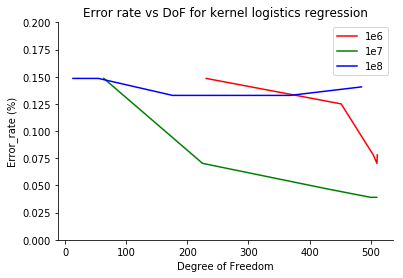

In [61]:
lambda_list = [0.0001,0.001,0.01,0.1,1]
sigma_list  = [1e6,1e7,1e8]
M = len(X_test)
N = len(X_train)

fig1 = plt.subplot()
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)

colors= ['red','green','blue']
sigmas  = ['1e6','1e7','1e8']
for k,sigma in enumerate(sigma_list):
    error_rate_list =[]
    dof_list = []

    for lambd in lambda_list:
        print("Lambda for this round is %f" % lambd)
        GRAM, alpha = mysvm_grad(verbose=False,sigma=sigma)
        result = np.zeros((N,M))
        for i in range(N):
            for j in range(M):
                result[i,j] = RBF(X_train[i],X_test[j],sigma= sigma)

        prob = 1/(1+np.exp(-np.dot(GRAM, alpha))) 
        pred = np.ones_like(y_train)
        pred[prob.reshape(511) < 0.5] =-1
        #print(np.sum(pred==y_train))
        #print(result)
        prob = 1/(1+np.exp(-np.dot(result.T, alpha))) 
        #print(prob)
        y_pred = np.ones_like(y_test)
        y_pred[prob.reshape(128) < 0.5] =-1
        error_rate = 1 - np.mean(y_pred==y_test)
        dof = np.trace(np.dot(np.linalg.inv(GRAM + lambd * np.identity(N)), GRAM))
        error_rate_list.append(error_rate)
        dof_list.append(dof)

    fig1.plot(dof_list,error_rate_list,color=colors[k],label=sigmas[k])
    
fig1.set(title= 'Error rate vs DoF for kernel logistics regression',ylabel='Error_rate (%)',xlabel='Degree of Freedom',ylim=(0,0.2))
fig1.legend()

We can see that when sigma equals to 1e7, lambda equals to 0.0001. The test error rate is the lowest. Sigma is large in this case becase we do not standardized our dataset so the kernel value will be very very close to zero if we set sigma to values like 1e3 or 1e4.

Next we will try to fit a SVM model using the one from sklearn. 

In [76]:
from sklearn.svm import SVC


svm_model = SVC(C = 10, gamma=0.0000001)
svm_model.fit(X_train, y_train)
pred= svm_model.predict(X_train)

pred= svm_model.predict(X_train)

print(np.sum(pred== y_train))

pred= svm_model.predict(X_test)
print('Error rate for test data: ', 1-np.mean(pred== y_test))


511
Error rate for test data:  0.0390625


For SVM, we use the same kind of kernel: RBF as in the kernel logistic regression. And the result of this SVM, for which I have tuned parameters, is comparable to that of kernel logistic regression, but it does not exceed it. Thus it seems like kernel logistic can yields similar result with sophisticated models like SVM if you pick up complex enough kernels like RBF.

# Exercise 2:

$$
\begin{aligned}
X = \begin{bmatrix}
    x_{11} &x_{12} & \dots  x_{1p} \\
    \dots \\
    x_{n1} &x_{n2} & \dots  x_{np} \\
\end{bmatrix}\
Z^{(1)} = \begin{bmatrix}
    z_{11} &z_{12} & \dots  z_{1M} \\
    \dots \\
    z_{n1} &z_{n2} & \dots  z_{nM} \\
\end{bmatrix}\   
Z^{(2)} = \begin{bmatrix}
    z_{11} &z_{12} & \dots  z_{1K} \\
    \dots \\
    z_{n1} &z_{n2} & \dots  z_{nK} \\
\end{bmatrix}\   
Y = \begin{bmatrix}
    y_{11} &y_{12} & \dots  y_{1K} \\
    \dots \\
    y_{n1} &y_{n2} & \dots  y_{nK} \\
\end{bmatrix}
\end{aligned}
$$

The size of the parameter matrices are not explicitly represented here. They should be conformable to the hidden units and X. 

### Forward Propagation:


$$
\begin{aligned}
Z^{(1)} &= X\beta^{(1)} + \alpha^{(1)}\\
A^{(1)} &=  \sigma^{(1)}(Z^{(1)}) \\
Z^{(2)} &=  A^{(1)}\beta^{(2)} + \alpha^{(2)} \\
\hat{Y} &= softmax(Z^{(2)}) \\
R &= -\sum^{n}_{i=1} \sum^{K}_{k=1} Y_{ik}log{\hat{Y}_{ik}} \\
\end{aligned}
$$

### Back Propagation:

In the back propagation, I will assume the $\sigma^{(2)}$ is the softmax function, and then the $\sum^{K}_{k=1}Z^{(2)}_{ik} = 1$.
$$
\begin{aligned}
\frac{\partial{R}}{\partial{Z^{(2)}_{ij} }} &= \hat{Y}_{ij} - Y_{ij} \\
\frac{\partial{R}}{\partial{Z^{(2)}}} &= \hat{Y} - Y \\
\frac{\partial{R}}{\partial{\beta^{(2)}}} &= {A^{(1)}}^T \frac{\partial{R}}{\partial{Z^{(2)}}}\\
\frac{\partial{R}}{\partial{\alpha^{(2)}}} &= {\mathbf{1}}^T \frac{\partial{R}}{\partial{Z^{(2)}}} \\
\frac{\partial{R}}{\partial{A^{(1)}}} &= \frac{\partial{R}}{\partial{Z^{(2)}}}  {\beta^{(2)}} ^T \\
\frac{\partial{R}}{\partial{Z^{(1)}}} &= \frac{\partial{R}}{\partial{A^{(1)}}} \circ \frac{\partial{A^{(1)}}}{\partial{Z^{(1)}}}\ \ \ where \frac{\partial{A^{(1)}}}{\partial{Z^{(1)}}} = (\frac{\partial{A^{(1)}_{ij}}}{\partial{Z^{(1)}_{ij}}})_{i,j}  \\ 
\frac{\partial{R}}{\partial{\beta^{(1)}}} &= {X}^T \frac{\partial{R}}{\partial{Z^{(1)}}}\\
\frac{\partial{R}}{\partial{\alpha^{(1)}}} &= {\mathbf{1}}^T \frac{\partial{R}}{\partial{Z^{(1)}}} \\
\end{aligned}
$$

# Exercise 3

### a)

In [53]:
import numpy as np
import matplotlib.pyplot as plt


class MY_NN(object):

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        loss = 0.0
        scores = None
        H1 = np.dot(X, W1) + b1.reshape(1,-1)
        A1 = np.maximum(H1, 0)
        H2 = np.dot(A1,W2) + b2.reshape(1,-1) #shape(N, H2)
        scores= H2

        if y is None:
            return scores


        loss = np.sum((H2 - y)**2 / N)
        loss += reg * (np.sum(W2**2) + np.sum(W1**2))

        grads = {}
        dZ2 = (H2 - y) * 2 / N

        dW2 =  np.dot(A1.T, dZ2) + 2 * reg* W2 #should be a (H,C) matrix
        db2 =  dZ2.sum(axis=0,)

        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * (A1 >0)
        dW1 =  np.dot(X.T, dZ1) + 2 * reg* W1
        db1 = dZ1.sum(axis=0,)
        grads['W1'] =dW1
        grads['W2'] =dW2
        grads['b1'] =db1
        grads['b2'] =db2

        return loss, grads

    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3,
            reg=5e-6, num_iters=200, verbose=False):
        num_train = X.shape[0]
        num_val = X_val.shape[0]

        loss_history = []
        val_loss_history = []

        for it in range(num_iters):
            loss, grads = self.loss(X, y=y, reg=reg)
            loss_history.append(loss)
            for param in self.params:
                self.params[param] -= learning_rate* grads[param]

            val_loss = np.sum((self.predict(X_val)- y_val)**2 /num_val)
            val_loss_history.append(val_loss)
            #learning_rate *= 0.99
        
        return {
          'loss_history': loss_history,
          'val_loss_history': val_loss_history,
        }

    def predict(self, X):
        y_pred = None
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        H1 = np.dot(X, W1) + b1.reshape(1,-1)
        A1 = np.maximum(H1, 0)
        H2 = np.dot(A1,W2) + b2.reshape(1,-1) #shape(N, H2)
        return H2

In [11]:
def sigmoid(x):
    return 1/(1+ np.exp(-x))

X = np.random.randn(1100,2)
Z = np.random.randn(1100).reshape(1100,1)
a1 = np.array([3,3]).reshape(2,1)
a2 = np.array([3,-3]).reshape(2,1)
Y = sigmoid(np.dot(X, a1)) + (np.dot(X, a2)**2) + 0.3 * Z

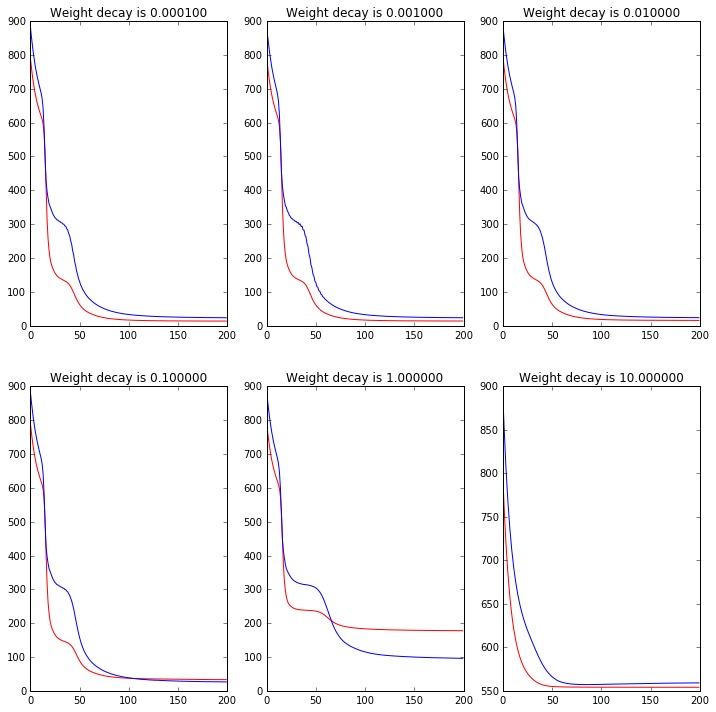

In [46]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


gs = gridspec.GridSpec(2,3)
fig = plt.figure(figsize= (12,12))

wd_list = 10 **np.linspace(-4,1,num=6)

for num,wd in enumerate(wd_list):
    Net = MY_NN(2,10,1)
    result =Net.train(X[0:100,], Y[0:100,],X[100:1100,],Y[100:1100,], learning_rate=0.03, reg= wd)
    
    fig1 = fig.add_subplot(gs[int(num/3), num%3])
    fig1.plot(result['loss_history'] ,color='r', label='train loss')
    fig1.plot(result['val_loss_history'],color='b', label='val loss')
    fig1.set(title= "Weight decay is %f" %wd )

### b)

The result above indicates that this regression problem is quite easy for the Two layer neural network. When the weight decay is around 0.001, the val error is pretty low. The overfitting is not quite obvious. But if we set weight decay too large, the capacity of model is insufficient to fit this model. So the loss is high in train and val.

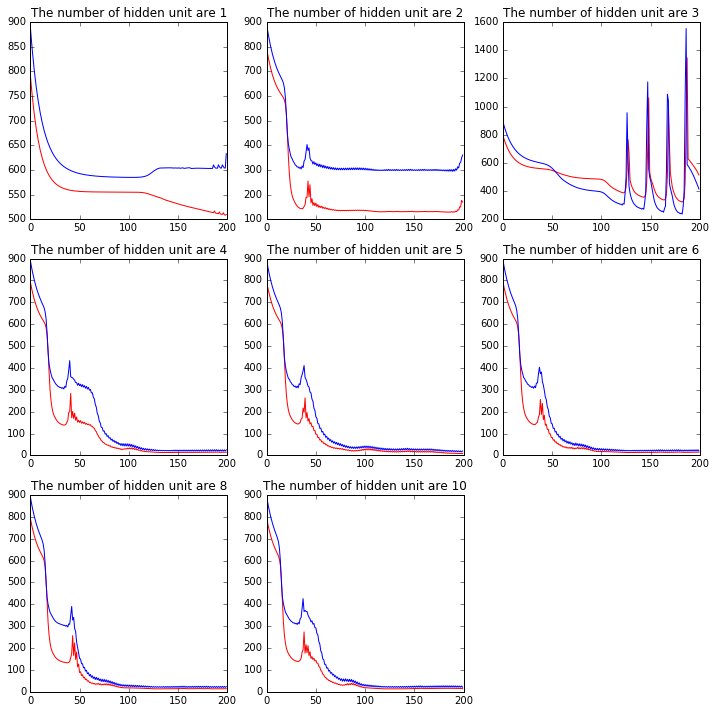

In [54]:
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize= (12,12))

hid_list = [1,2,3,4,5,6,8,10]

for num,hid in enumerate(hid_list):
    Net = MY_NN(2,hid,1)
    result =Net.train(X[0:100,], Y[0:100,],X[100:1100,],Y[100:1100,], learning_rate=0.025, reg= 0.001)
    
    fig1 = fig.add_subplot(gs[int(num/3), num%3])
    fig1.plot(result['loss_history'] ,color='r', label='train loss')
    fig1.plot(result['val_loss_history'],color='b', label='val loss')
    fig1.set(title= "The number of hidden unit are %d" % hid)

### c)

When the number of hidden units are over 4. The performance is competitive with the 10-hidden-unit version.